# Modeling Neighborhood Dynamics with `geosnap`

The geosnap package is designed for geodemographic analysis and regionalization applied to longitudinal data. Following those analyses, it also provides tools for modeling neighborhood composition into the future using spatial and temporal transition rules learned from the past.

In [1]:
from geosnap import DataStore
from geosnap.io import get_acs
from geosnap.analyze import cluster, regionalize

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


In [2]:
from geosnap.visualize import plot_timeseries, animate_timeseries

## Examining Data

In [3]:
store = DataStore()

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


The DataStore class provides access to hundreds of neighbrohood indicators for the U.S. collected from federal agencies. We store these datasets in the cloud and stream them on demand. But if you plan on doing repeated analyses you can store the data locally (which we've already done on the JupyterHub)

In [4]:
dir(store)

['acs',
 'blocks_2000',
 'blocks_2010',
 'codebook',
 'counties',
 'ejscreen',
 'ltdb',
 'msa_definitions',
 'msas',
 'ncdb',
 'nces',
 'show_data_dir',
 'states',
 'tracts_1990',
 'tracts_2000',
 'tracts_2010']

Each dataset in the datastore covers the entire country for a single time period. To generate a dataset for a single place, geosnap provides several convenience functions

In [5]:
chicago = get_acs(store, county_fips='17031', level='tract', years=list(range(2013, 2017)))  # without specifying a subset of years, we get everything

(If several people hit the server at once, things can slow down. There's a local copy of the data in that case)

In [6]:
# chicago = gpd.read_parquet("data/chicago_acs.parquet")

In [7]:
chicago.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5276 entries, 0 to 5275
Columns: 161 entries, geoid to p_vietnamese_persons
dtypes: float64(158), geometry(1), int64(1), object(1)
memory usage: 6.5+ MB


In [8]:
chicago.head()

geoid  n_mexican_pop  n_cuban_pop  n_puerto_rican_pop  n_russian_pop  \
0  17031010100          235.0          0.0                84.0            0.0   
1  17031010201         1745.0          0.0                38.0           60.0   
2  17031010202          480.0         16.0                 6.0            8.0   
3  17031010300          636.0         54.0                16.0          152.0   
4  17031010400          269.0         79.0                67.0           20.0   

   n_italian_pop  n_german_pop  n_irish_pop  n_scandaniavian_pop  \
0           31.0          78.0         21.0                  0.0   
1           81.0          31.0         63.0                  0.0   
2           34.0         104.0         55.0                  0.0   
3           38.0         138.0        190.0                  0.0   
4          111.0         206.0        177.0                  0.0   

   n_foreign_born_pop  ...  n_chinese_persons  n_filipino_persons  \
0               996.0  ...                NaN                 NaN   
1              2530.0  ...                NaN                 NaN   
2               676.0  ...                NaN                 NaN   
3              1951.0  ...                NaN                 NaN   
4               822.0  ...                NaN                 NaN   

   n_japanese_persons  n_korean_persons  n_vietnamese_persons  \
0                 NaN               NaN                   NaN   
1                 NaN               NaN                   NaN   
2                 NaN               NaN                   NaN   
3                 NaN               NaN                   NaN   
4                 NaN               NaN                   NaN   

   p_chinese_persons  p_filipino_persons  p_japanese_persons  \
0                NaN                 NaN                 NaN   
1                NaN                 NaN                 NaN   
2                NaN                 NaN                 NaN   
3                NaN                 NaN                 NaN   
4                NaN                 NaN                 NaN   

   p_korean_persons  p_vietnamese_persons  
0               NaN                   NaN  
1               NaN                   NaN  
2               NaN                   NaN  
3               NaN                   NaN  
4               NaN                   NaN  

[5 rows x 161 columns]

There are also convenient plotting methods for looking at change over time. A useful feature here is that the choropleth bins are the same for each time period, making it easy to see change over time

SubplotGrid(nrows=2, ncols=2, length=4)

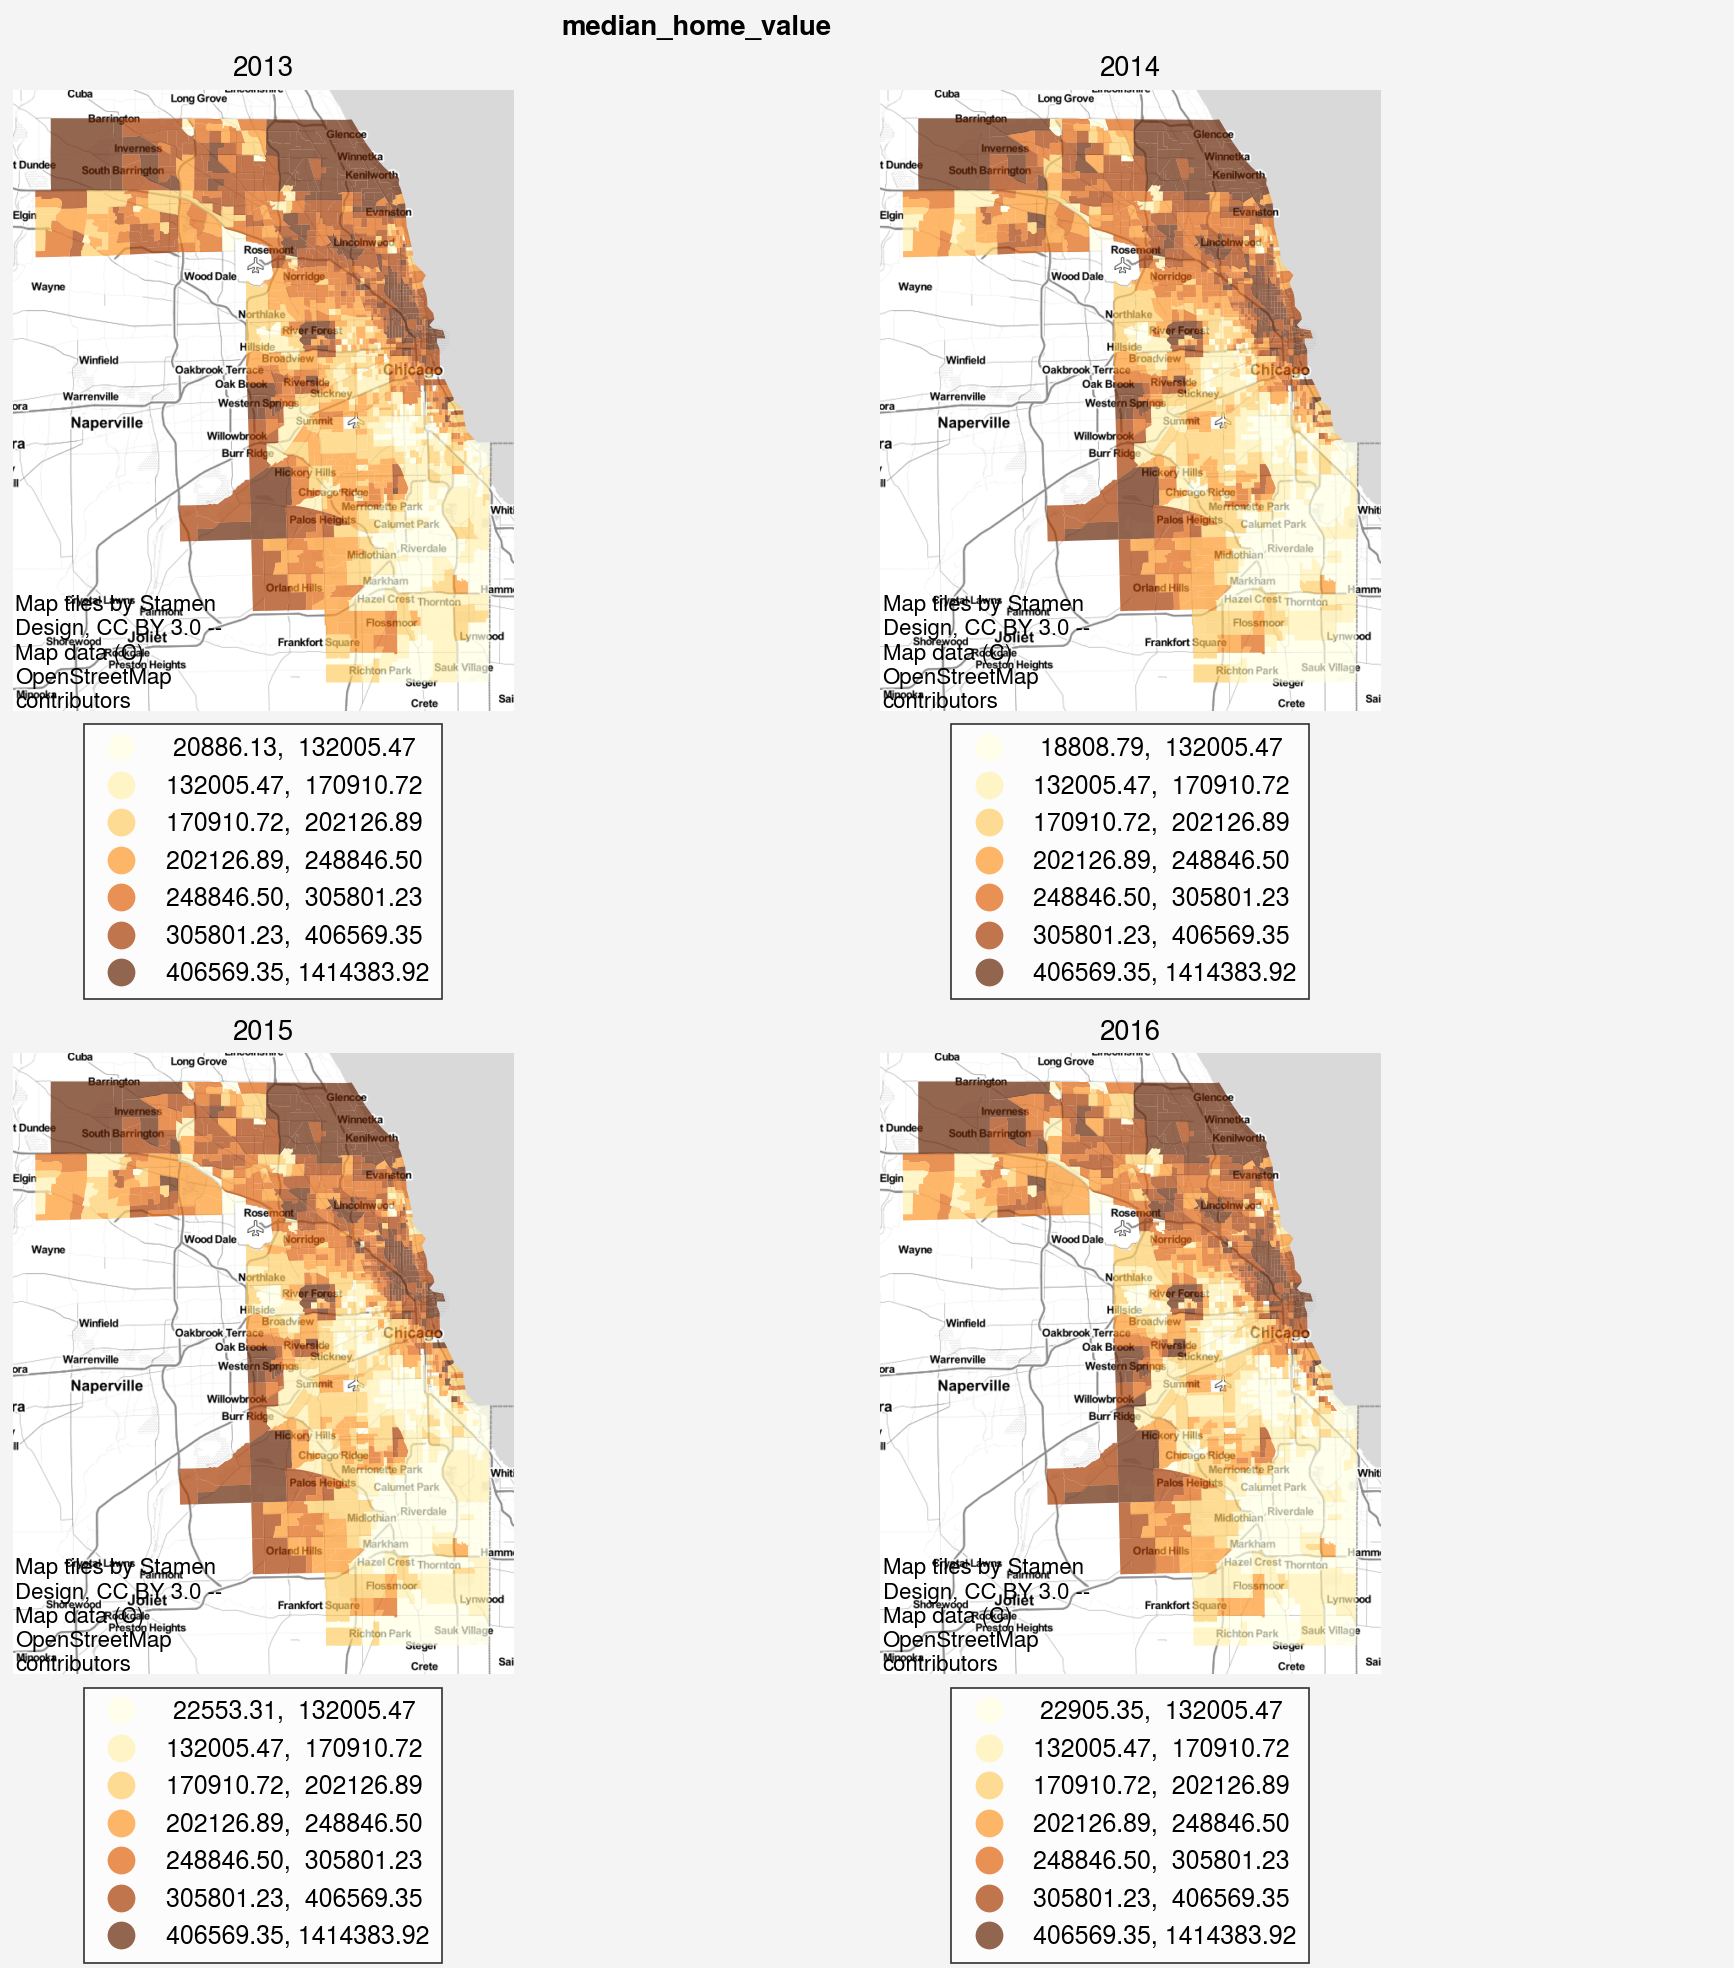

In [9]:
plot_timeseries(chicago, "median_home_value", scheme='quantiles', k=7, nrows=2, ncols=2, cmap='YlOrBr')

Still it can be difficult to see minute changes across the various maps. The `animate_timeseries` function can make it easier to see what's happening, like the steady income decline in Midlothian near the southern edge of the region

In [ ]:
animate_timeseries(chicago, 'median_home_value', scheme='quantiles', k=7, cmap='YlOrBr', filename='figs/chicago_income_change.gif', fps=1.5)

In [11]:
from IPython.display import Image

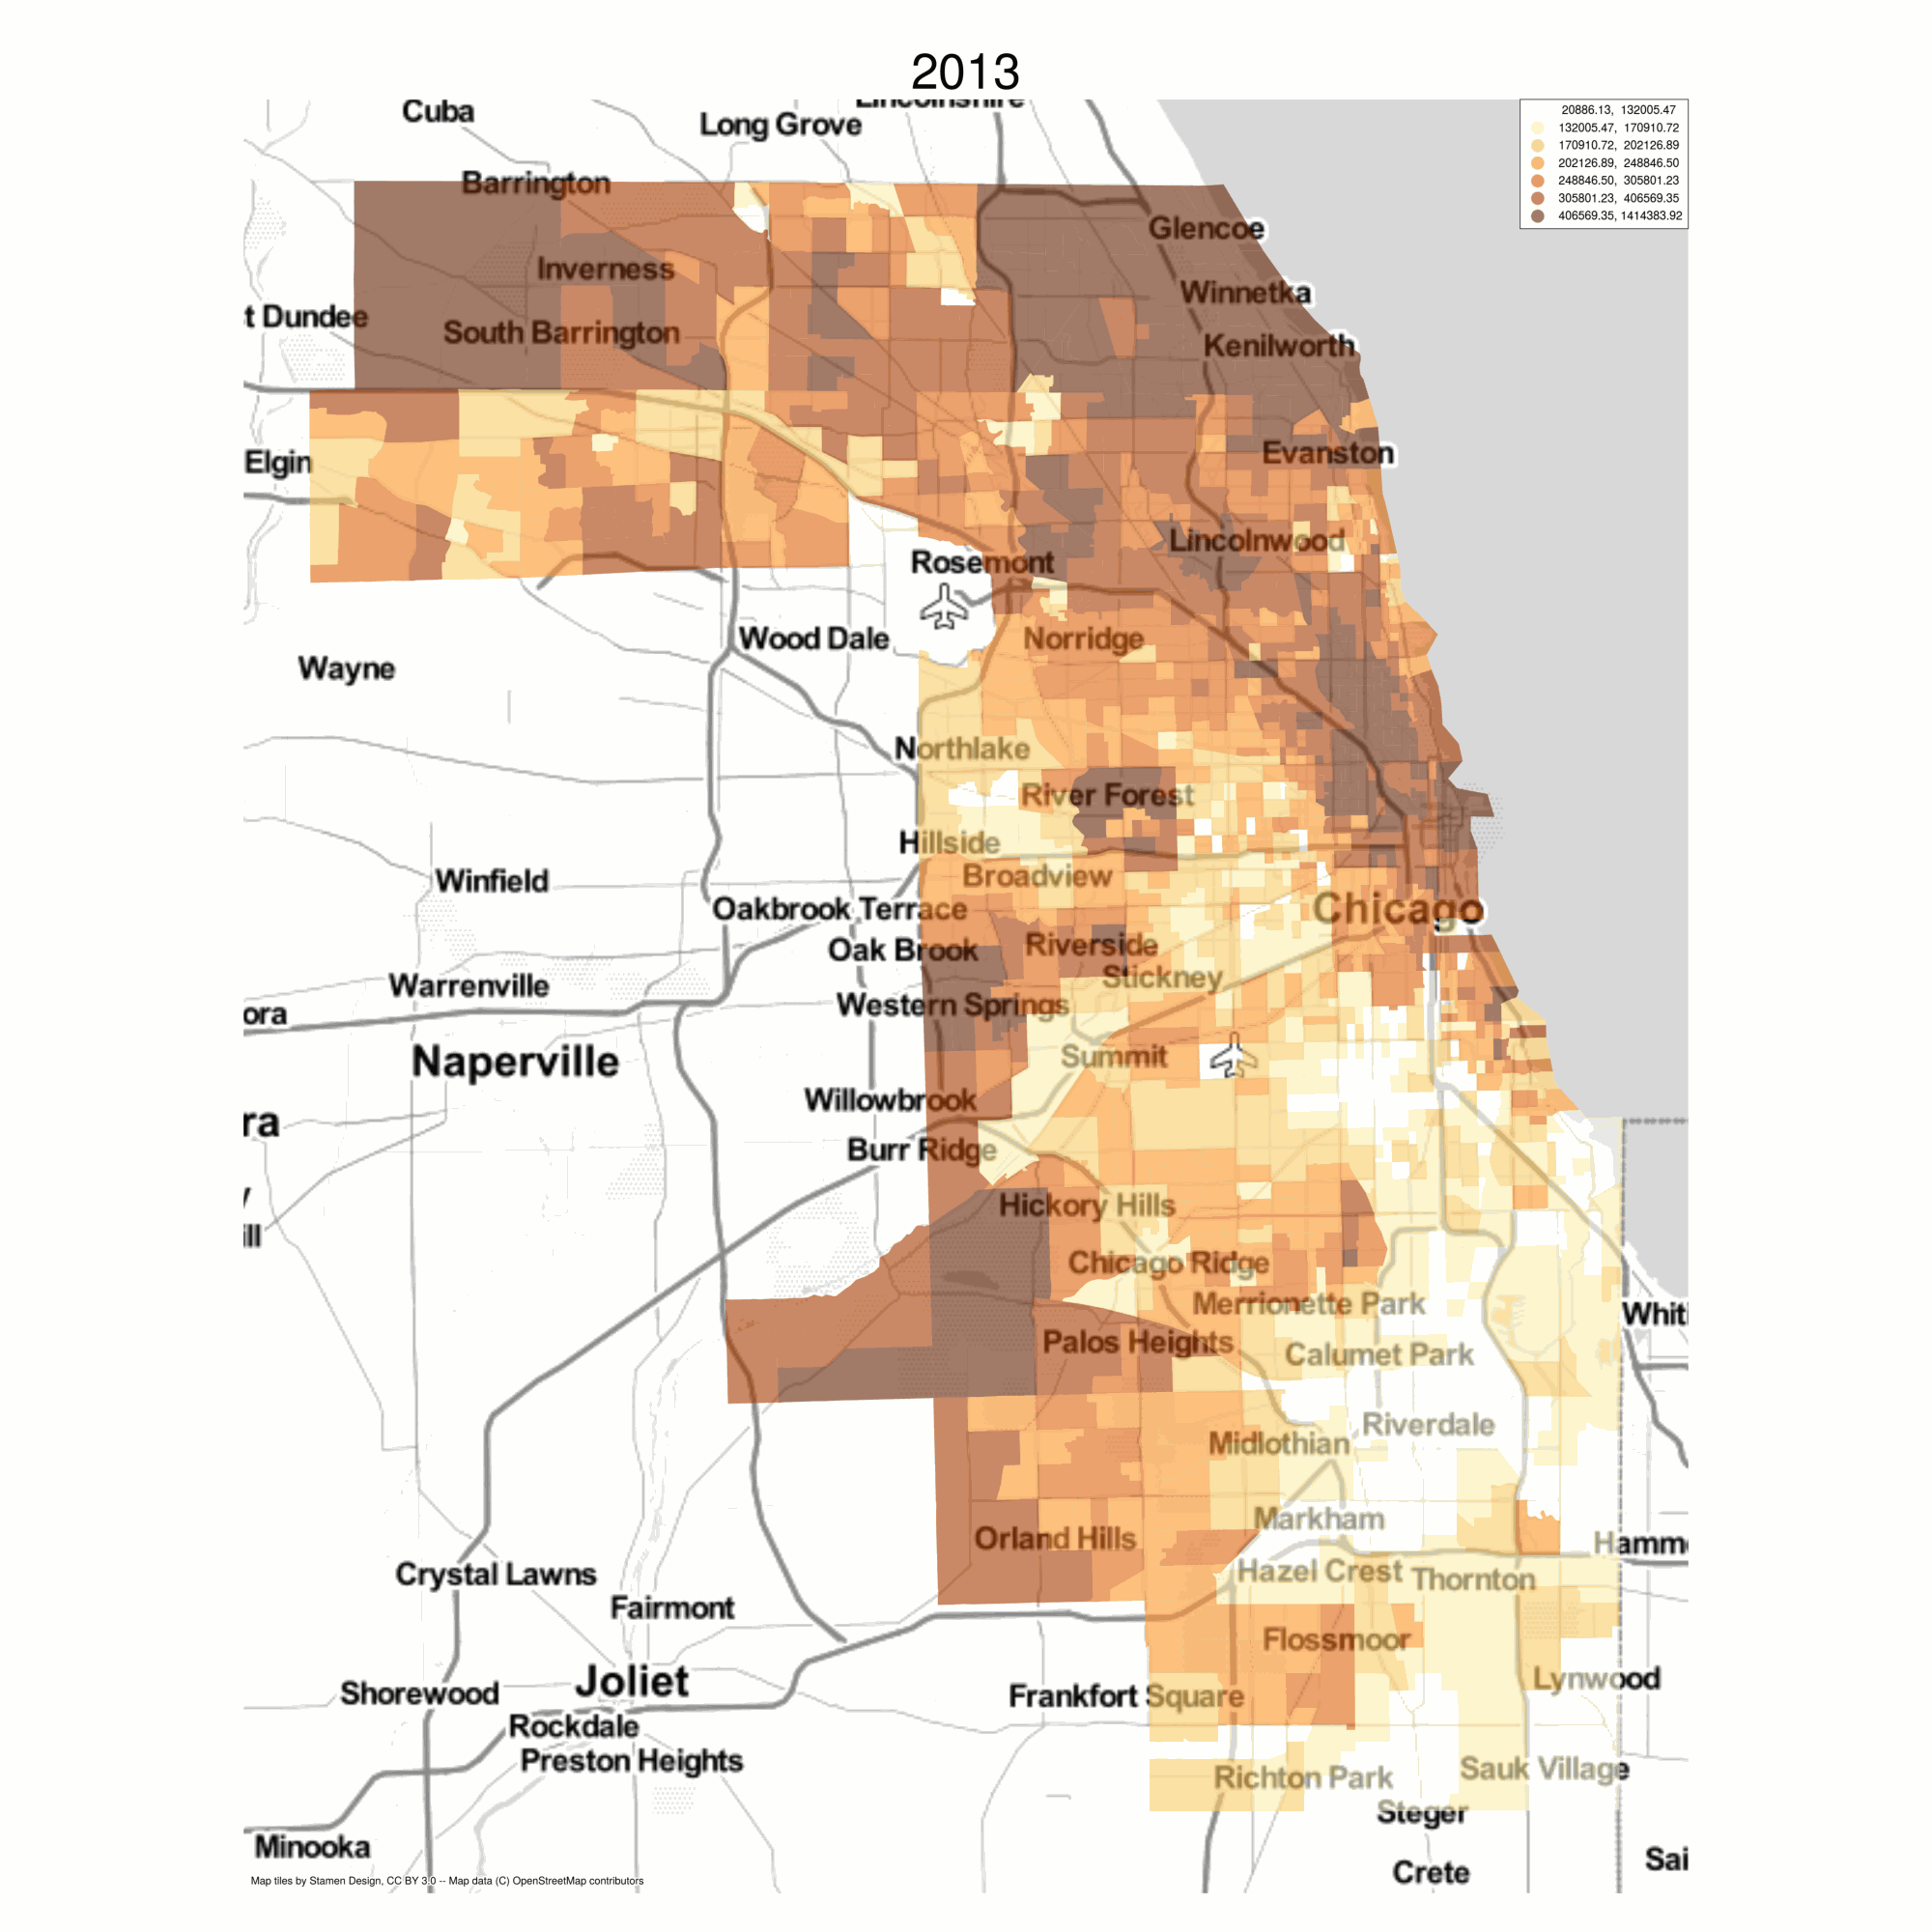

In [12]:
Image("figs/chicago_income_change.gif", width=800)

Note here that we're comparing overlapping samples from the ACS 5-year survey, which the Census Bureau recommends against. Here it just makes a good example :)

## Modeling Neighborhood Types

With `geosnap`, it's possible to look at *temporal* geodemographics without writing much code. Under the hood, the package provides tools for scaling each dataset within its own time period, adjusting currency values for inflation, and ensuring that times, variables, and geometries stay aligned properly. Together those tools make it easy to explore how different portions of the region transition into different neighborhood types over time, and if desired, model the evolution of neighborhood change as a spatial Markov process.

Any variables could be used to examine neighborhood transitions, but we'll return to the simple set of sociodemographic veriables used before to understand if/how patterns of racial and socioeconomic segregation and neighborhood partitioning unfold over time

In [13]:
columns = ['median_household_income', 'median_home_value', 'p_asian_persons', 'p_hispanic_persons', 'p_nonhisp_black_persons', 'p_nonhisp_white_persons']

In [39]:
cluster?

Signature:
cluster(
    gdf,
    n_clusters=6,
    method=None,
    best_model=False,
    columns=None,
    verbose=False,
    temporal_index='year',
    unit_index='geoid',
    scaler='std',
    pooling='fixed',
    random_state=None,
    cluster_kwargs=None,
    model_colname=None,
    return_model=False,
)
Docstring:
Create a geodemographic typology by running a cluster analysis on the study area's neighborhood attributes.

Parameters
----------
gdf : geopandas.GeoDataFrame, required
    long-form GeoDataFrame containing neighborhood attributes
n_clusters : int, required
    the number of clusters to model. The default is 6).
method : str in ['kmeans', 'ward', 'affinity_propagation', 'spectral','gaussian_mixture', 'hdbscan'], required
    the clustering algorithm used to identify neighborhood types
best_model : bool, optional
    if using a gaussian mixture model, use BIC to choose the best
    n_clusters. (the default is False).
columns : list-like, required
    subset of columns o

In [14]:
chicago_ward = cluster(chicago, columns=columns, method='ward', n_clusters=6)

The simplest version of the function returns the geodataframe with new cluster labels appended

In [15]:
chicago_ward.head()

year        geoid  n_mexican_pop  n_cuban_pop  n_puerto_rican_pop  \
0  2013  17031010100          235.0          0.0                84.0   
1  2013  17031010201         1745.0          0.0                38.0   
2  2013  17031010202          480.0         16.0                 6.0   
3  2013  17031010300          636.0         54.0                16.0   
4  2013  17031010400          269.0         79.0                67.0   

   n_russian_pop  n_italian_pop  n_german_pop  n_irish_pop  \
0            0.0           31.0          78.0         21.0   
1           60.0           81.0          31.0         63.0   
2            8.0           34.0         104.0         55.0   
3          152.0           38.0         138.0        190.0   
4           20.0          111.0         206.0        177.0   

   n_scandaniavian_pop  ...  n_filipino_persons  n_japanese_persons  \
0                  0.0  ...                 NaN                 NaN   
1                  0.0  ...                 NaN                 NaN   
2                  0.0  ...                 NaN                 NaN   
3                  0.0  ...                 NaN                 NaN   
4                  0.0  ...                 NaN                 NaN   

   n_korean_persons  n_vietnamese_persons  p_chinese_persons  \
0               NaN                   NaN                NaN   
1               NaN                   NaN                NaN   
2               NaN                   NaN                NaN   
3               NaN                   NaN                NaN   
4               NaN                   NaN                NaN   

   p_filipino_persons  p_japanese_persons  p_korean_persons  \
0                 NaN                 NaN               NaN   
1                 NaN                 NaN               NaN   
2                 NaN                 NaN               NaN   
3                 NaN                 NaN               NaN   
4                 NaN                 NaN               NaN   

   p_vietnamese_persons  ward  
0                   NaN     0  
1                   NaN     0  
2                   NaN     0  
3                   NaN     2  
4                   NaN     2  

[5 rows x 162 columns]

SubplotGrid(nrows=2, ncols=2, length=4)

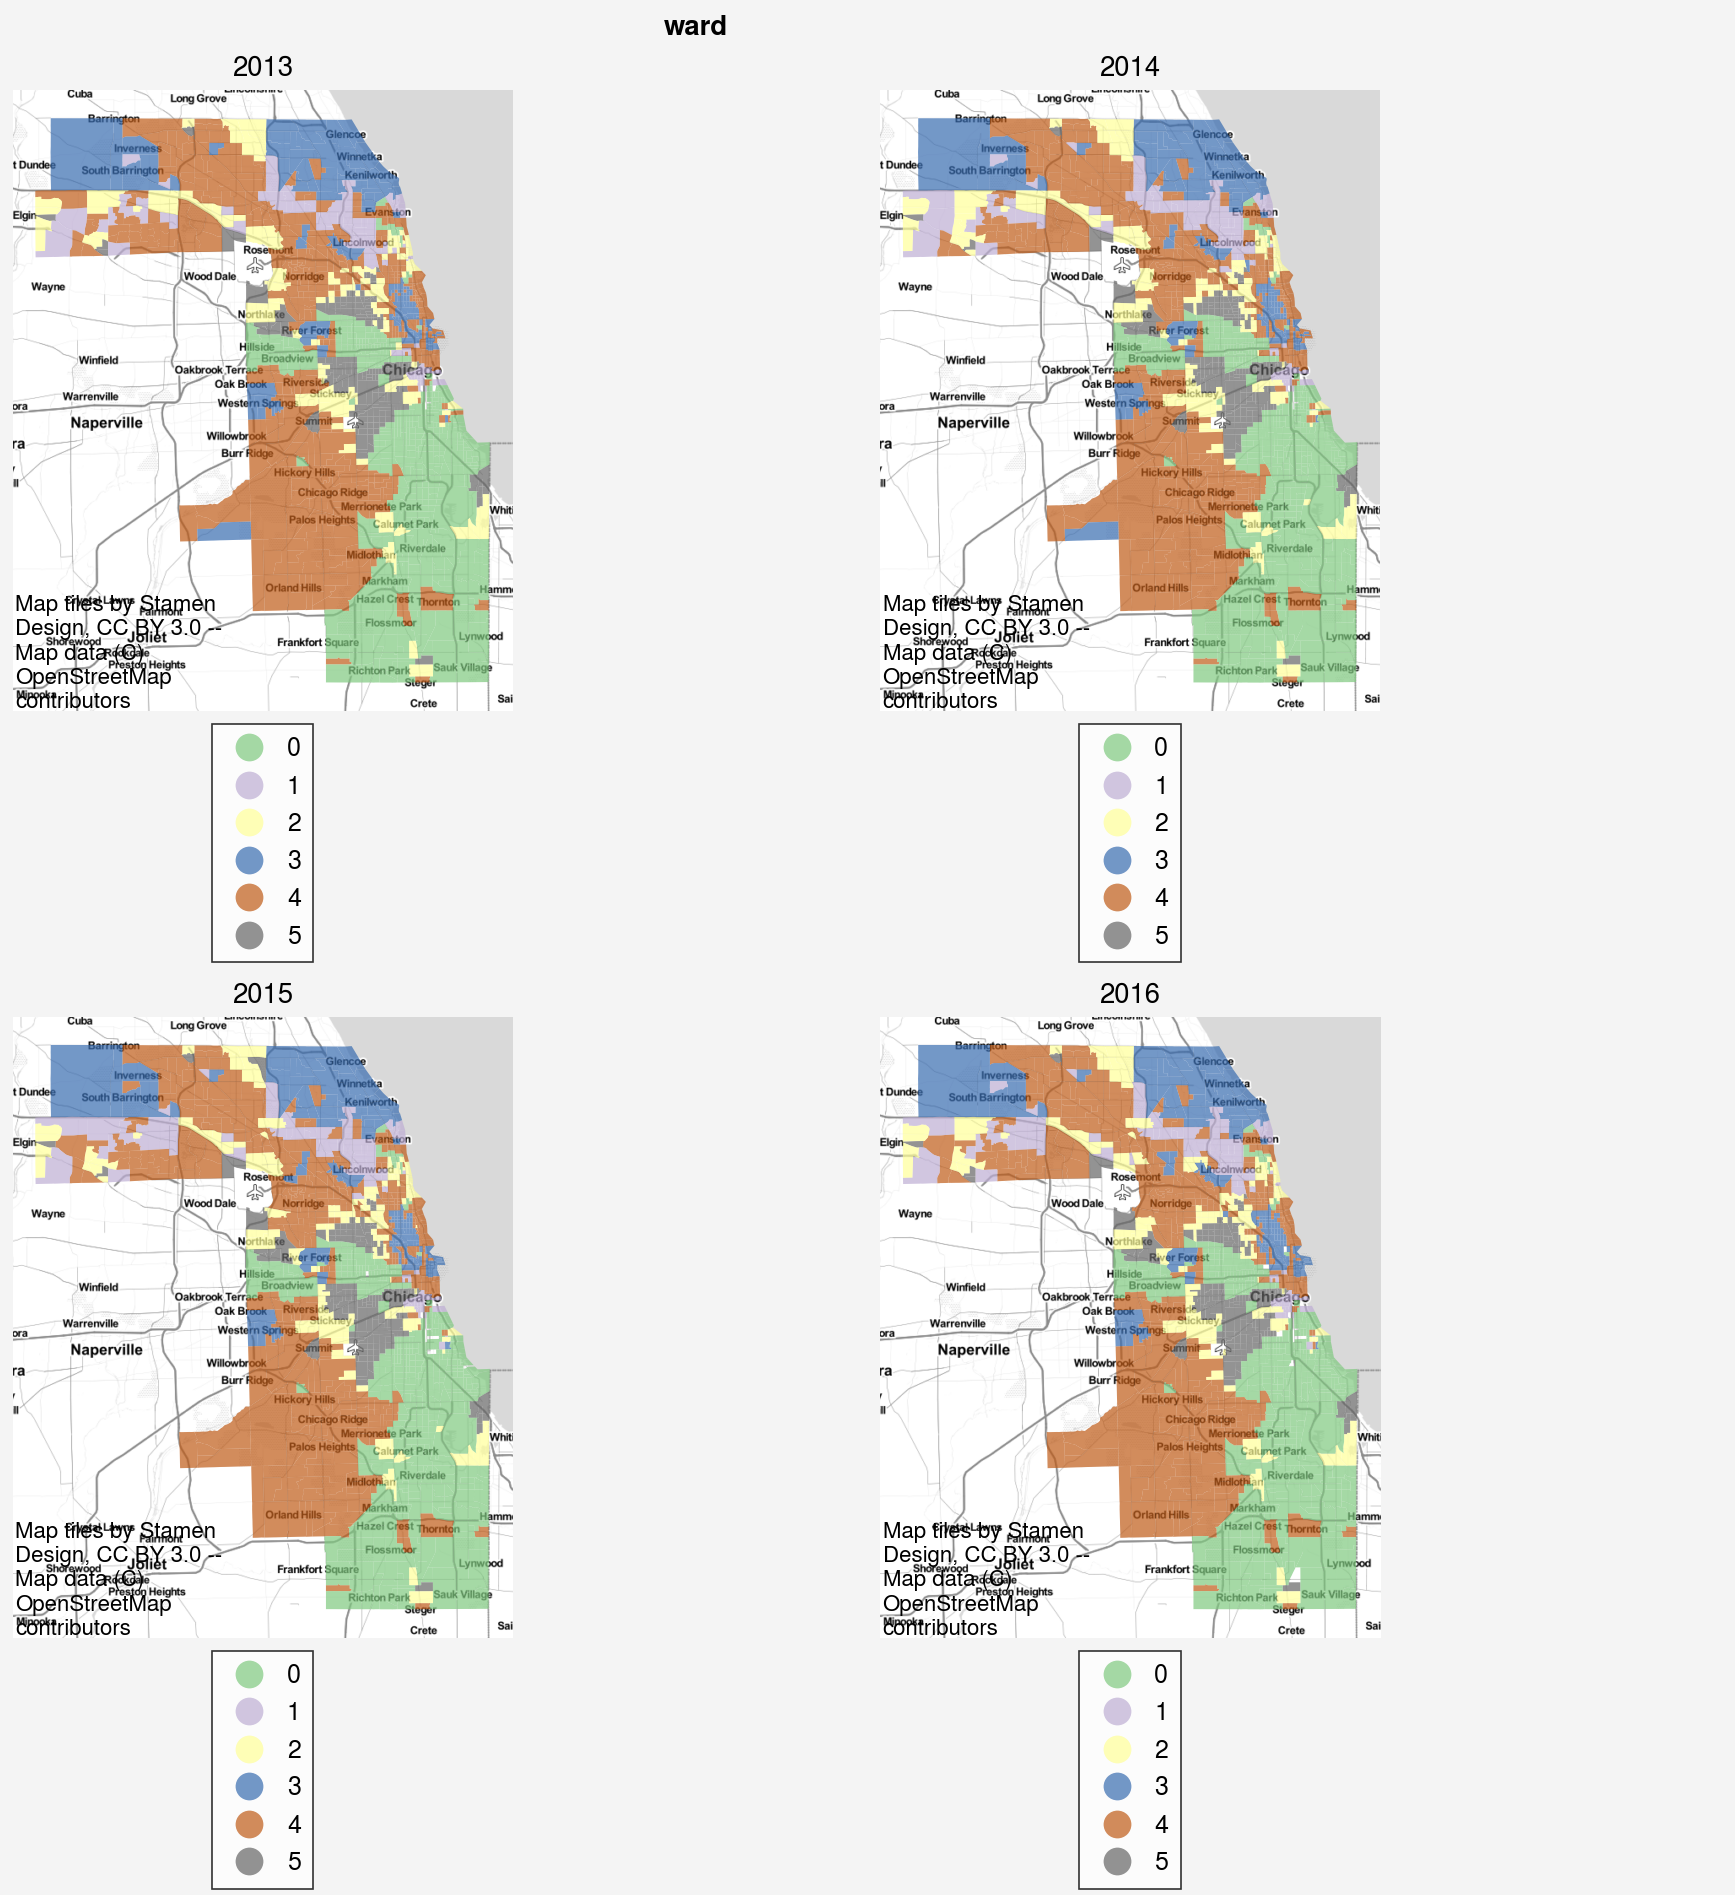

In [16]:
plot_timeseries(chicago_ward, 'ward', categorical=True, nrows=2, ncols=2)

In [ ]:
animate_timeseries(chicago_ward, 'ward', categorical=True, filename='figs/chicago_type_change.gif', fps=1.5)

The vast majority of tracts are assigned to the same geodemographic type in each time period, but some transition into different types over time. The ones that do transition tend to be those on the edges of large contiguous groups (i.e. change tends to happen along the periphery and move inward, implying a certain kind of spatial dynamic)

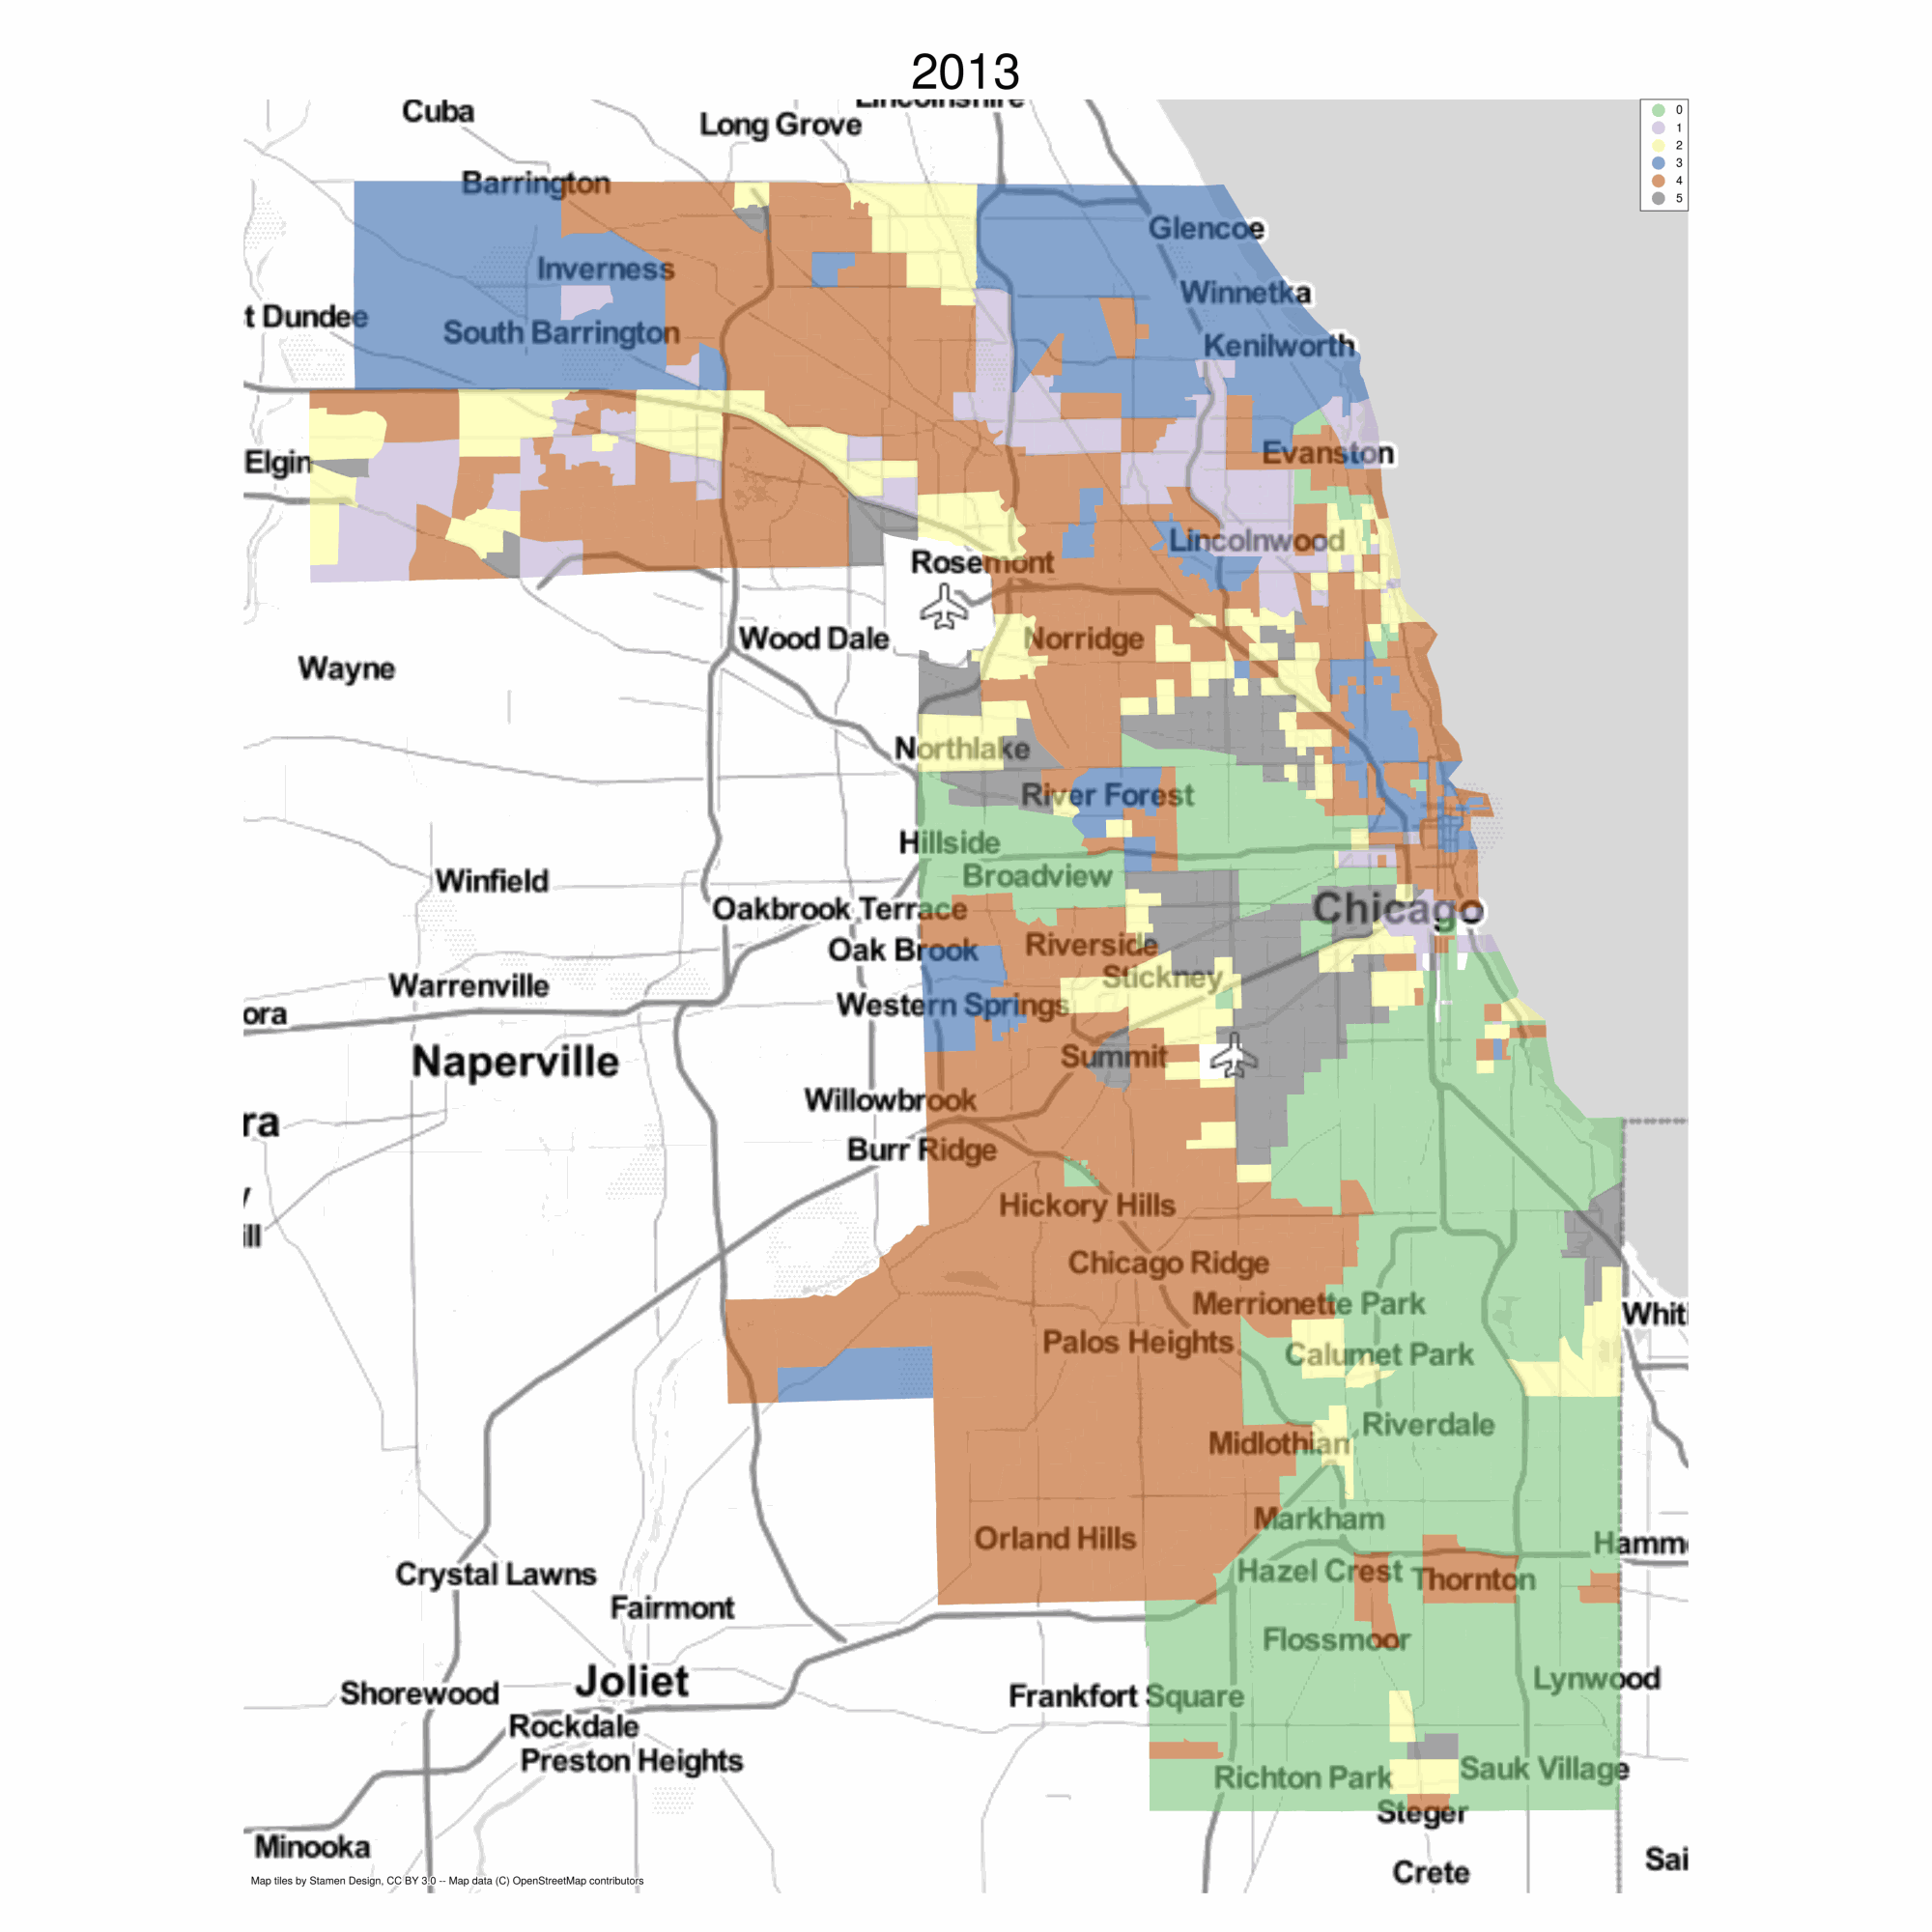

In [18]:
Image('figs/chicago_type_change.gif', width=800)

If we add the argument `return_model=True`, then the function returns the same geodataframe as before, as well as a `ModelResults` class that holds additional diagnostic measures, as well as plotting and simulation methods

In [19]:
chicago_ward, chi_model = cluster(chicago, columns=columns, method='ward', n_clusters=6, return_model=True)

In [20]:
type(chi_model)

geosnap.analyze._model_results.ModelResults

For example, the `silhouette_scores` attribute makes computing a silhouette coefficient for the cluster model a one-liner:

In [21]:
chi_model.silhouette_scores

silhouette_score        geoid  year  \
0             0.136093  17031010100  2013   
1             0.099845  17031010201  2013   
2            -0.178627  17031010202  2013   
3             0.188316  17031010300  2013   
4            -0.141755  17031010400  2013   
...                ...          ...   ...   
5268          0.522373  17031843500  2016   
5269          0.603410  17031843600  2016   
5270          0.019169  17031843700  2016   
5271          0.102991  17031843800  2016   
5272          0.680673  17031843900  2016   

                                               geometry  
0     MULTIPOLYGON (((-87.67720 42.02294, -87.67628 ...  
1     MULTIPOLYGON (((-87.68465 42.01948, -87.68432 ...  
2     MULTIPOLYGON (((-87.67683 42.01941, -87.67674 ...  
3     MULTIPOLYGON (((-87.67133 42.01937, -87.67121 ...  
4     MULTIPOLYGON (((-87.66345 42.01283, -87.66321 ...  
...                                                 ...  
5268  MULTIPOLYGON (((-87.70504 41.84452, -87.70479 ...  
5269  MULTIPOLYGON (((-87.61150 41.81128, -87.61125 ...  
5270  MULTIPOLYGON (((-87.69683 41.94967, -87.69681 ...  
5271  MULTIPOLYGON (((-87.64554 41.80886, -87.64542 ...  
5272  MULTIPOLYGON (((-87.59295 41.77508, -87.59278 ...  

[5224 rows x 4 columns]

Each observation is given its own silhouette score to identify potential spatial outliers, or the measures can be summarized to provide an aggregate statistic

In [22]:
chi_model.silhouette_scores.silhouette_score.mean()

0.35971262107670565

Since the data are indexed by time, we can also examine whether certain time periods have a poorer fit versus others:

In [23]:
chi_model.silhouette_scores.groupby('year').silhouette_score.mean()

year
2013    0.362116
2014    0.361529
2015    0.359077
2016    0.356111
Name: silhouette_score, dtype: float64

## Analyzing Neighborhood Change

With the cluster model in hand, each census tract is represented as a series of neighborhood types over time (i.e. what we plotted above). To understand which neighborhoods have experienced the most change, the `ModelResults` class implements a method called "LINCS", the Local Indicator of Neighborhood Change. The `lincs` attribute measures how often a given spatial unit shares its cluster assignment with the other units over time.

If a "neighborhood" is grouped with many different neighborhoods over time (rather than joining a single group with the same members repeatedly), then it shows more variation and thus a higher LINC score

In [24]:
chi_lincs = chi_model.lincs

In [25]:
chi_lincs

geoid                                           geometry  2013  \
0     17031010100  MULTIPOLYGON (((-87.67720 42.02294, -87.67628 ...   0.0   
1     17031010201  MULTIPOLYGON (((-87.68465 42.01948, -87.68432 ...   0.0   
2     17031010202  MULTIPOLYGON (((-87.67683 42.01941, -87.67674 ...   0.0   
3     17031010300  MULTIPOLYGON (((-87.67133 42.01937, -87.67121 ...   2.0   
4     17031010400  MULTIPOLYGON (((-87.66345 42.01283, -87.66321 ...   2.0   
...           ...                                                ...   ...   
1304  17031843500  MULTIPOLYGON (((-87.70504 41.84452, -87.70479 ...   0.0   
1305  17031843600  MULTIPOLYGON (((-87.61150 41.81128, -87.61125 ...   0.0   
1306  17031843700  MULTIPOLYGON (((-87.69683 41.94967, -87.69681 ...   4.0   
1307  17031843800  MULTIPOLYGON (((-87.64554 41.80886, -87.64542 ...   0.0   
1308  17031843900  MULTIPOLYGON (((-87.59295 41.77508, -87.59278 ...   0.0   

      2014  2015  2016      linc  
0      0.0   0.0   0.0  0.017857  
1      0.0   0.0   0.0  0.017857  
2      0.0   0.0   0.0  0.017857  
3      2.0   2.0   2.0  0.303371  
4      2.0   2.0   2.0  0.303371  
...    ...   ...   ...       ...  
1304   0.0   0.0   0.0  0.017857  
1305   0.0   0.0   0.0  0.017857  
1306   4.0   4.0   3.0  0.994307  
1307   0.0   0.0   0.0  0.017857  
1308   0.0   0.0   0.0  0.017857  

[1309 rows x 7 columns]

<AxesSubplot:>

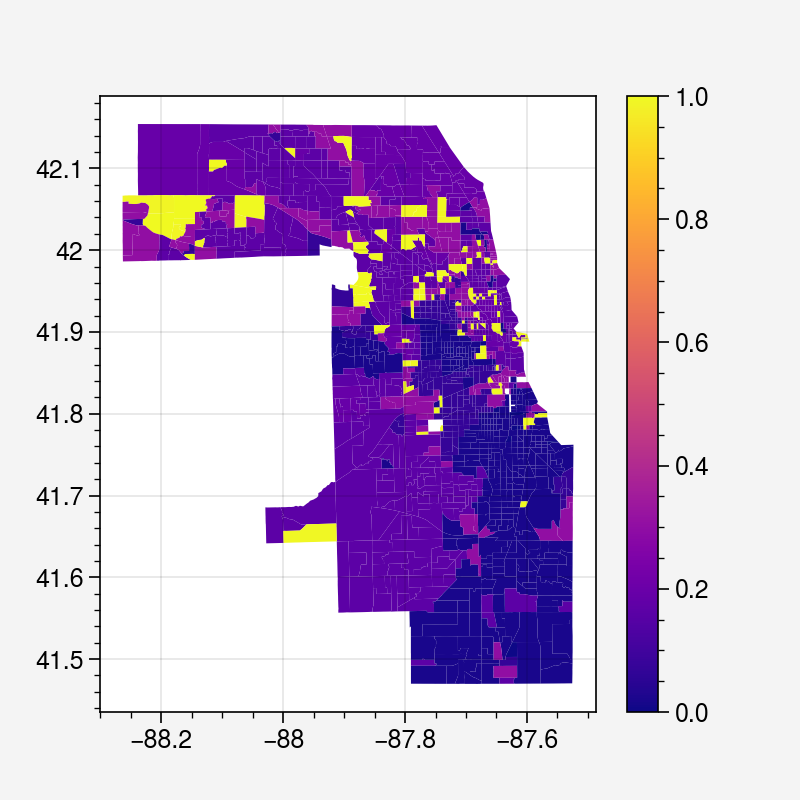

In [26]:
chi_model.lincs.plot('linc',legend=True, cmap='plasma')

Yellow places have changed the most in our cluster model, and blue places have remained the most stagnant. We can use the LISA statistics from `esda` to locate hotspots of change or stagnation

<AxesSubplot:ylabel='Density'>

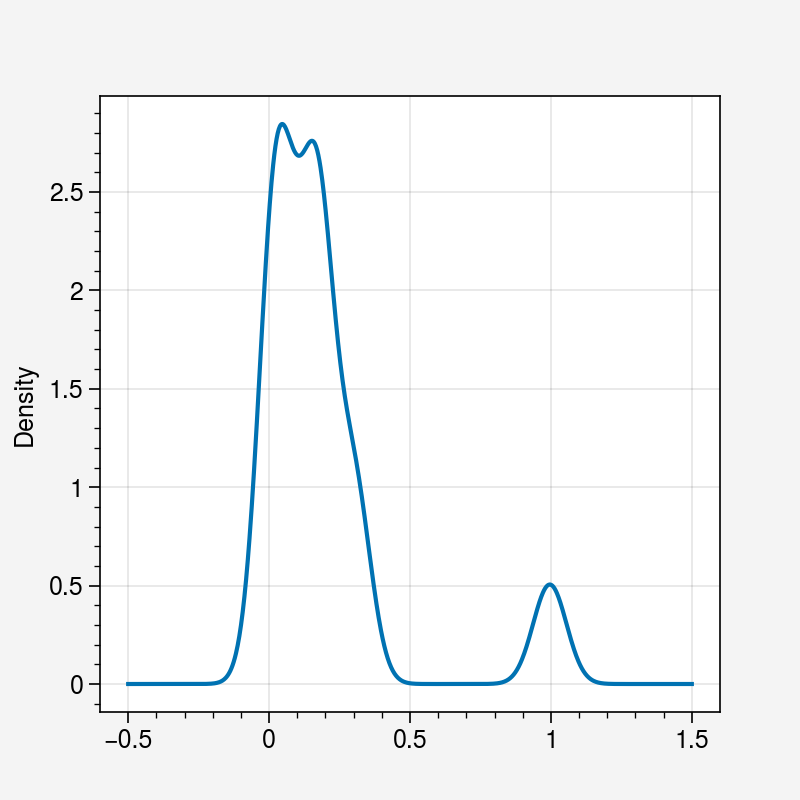

In [27]:
chi_model.lincs.linc.plot(kind='density')

In [28]:
from esda import Moran_Local

In [29]:
from libpysal.weights import Queen

In [30]:
w = Queen.from_dataframe(chi_model.lincs)

In [31]:
linc_lisa = Moran_Local(chi_model.lincs.linc, w)

Recall that the LISA statistic measures the association between a focal observation and its neighbors. When we have spatial units (i.e. tracts) with a high LINC score, and their neighboring tracts *also* have high LINC scores, then we've found a local pocket of neighborhood change.

In [32]:
linc_lisa.Is

array([ 0.19094133, -0.38635302, -0.13315014, ...,  2.09900215,
        0.3517673 ,  0.49985707])

<AxesSubplot:>

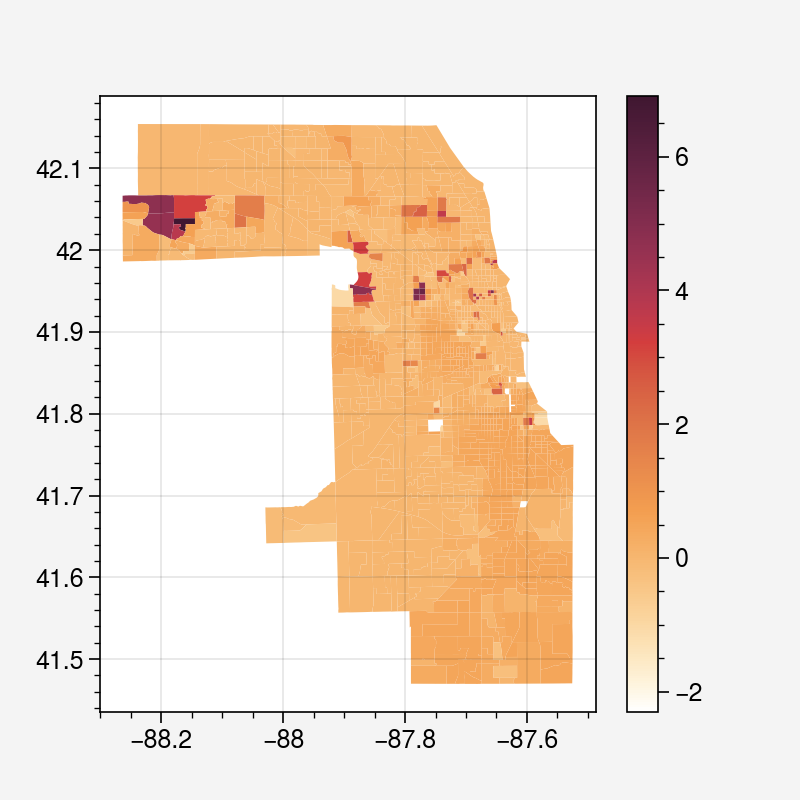

In [33]:
chi_model.lincs.assign(i=linc_lisa.Is).plot('i', legend=True)

## Modeling Neighborhood Transitions

We can also use the sequence of labels to create a spatial Markov transition model. These models examine how often one neighborhood type transitions into another type--then how these transition rates change under different conditions of spatial context

In [34]:
from geosnap.visualize import plot_transition_matrix

array([<AxesSubplot:title={'center':'Global'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 0'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 1'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 2'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 3'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 4'}>,
       <AxesSubplot:title={'center':'Modal Neighbor - 5'}>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

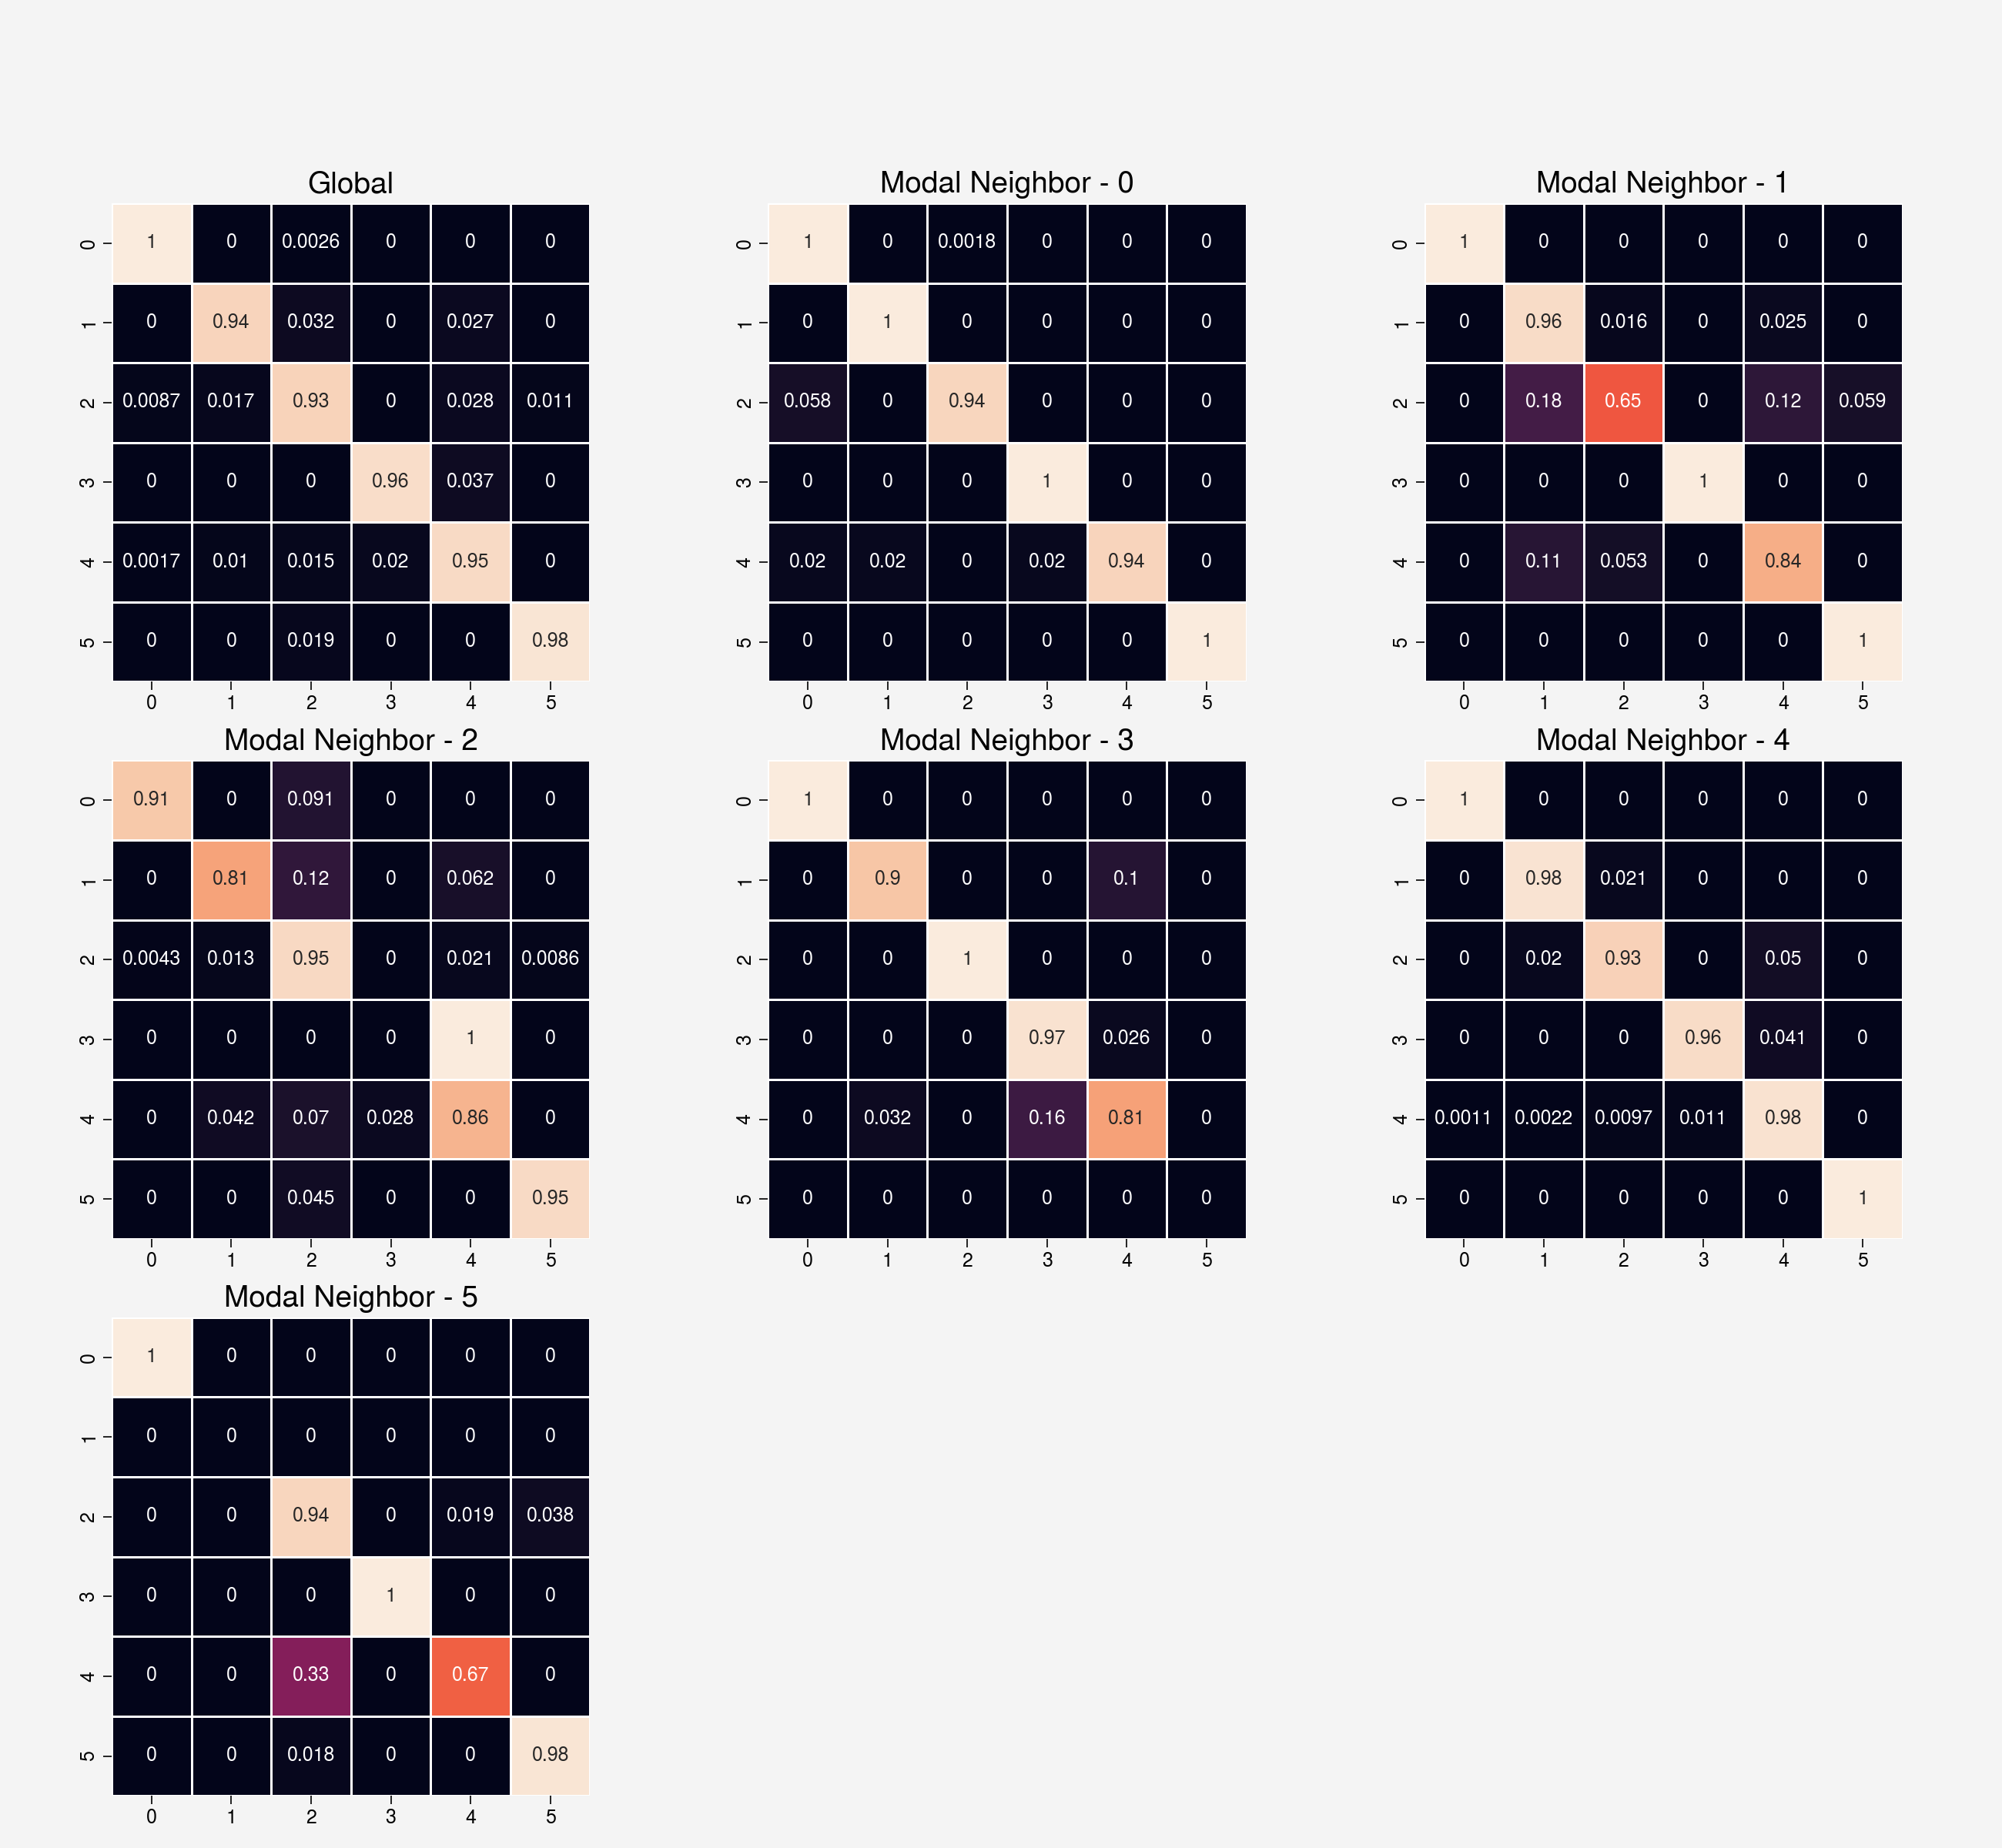

In [35]:
plot_transition_matrix(chicago_ward, cluster_col='ward')

And we can use those transition rates to make predictions about future conditions

In [36]:
future = chi_model.predict_markov_labels(time_steps=5, increment=1)

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/_model_results.py:705: UserWarning: No base_year provided. Using the last period for which labels are known:  2016 
  warn(


In [ ]:
animate_timeseries(future, 'predicted', categorical=True, filename='figs/chicago_predictions.gif', fps=1.5)

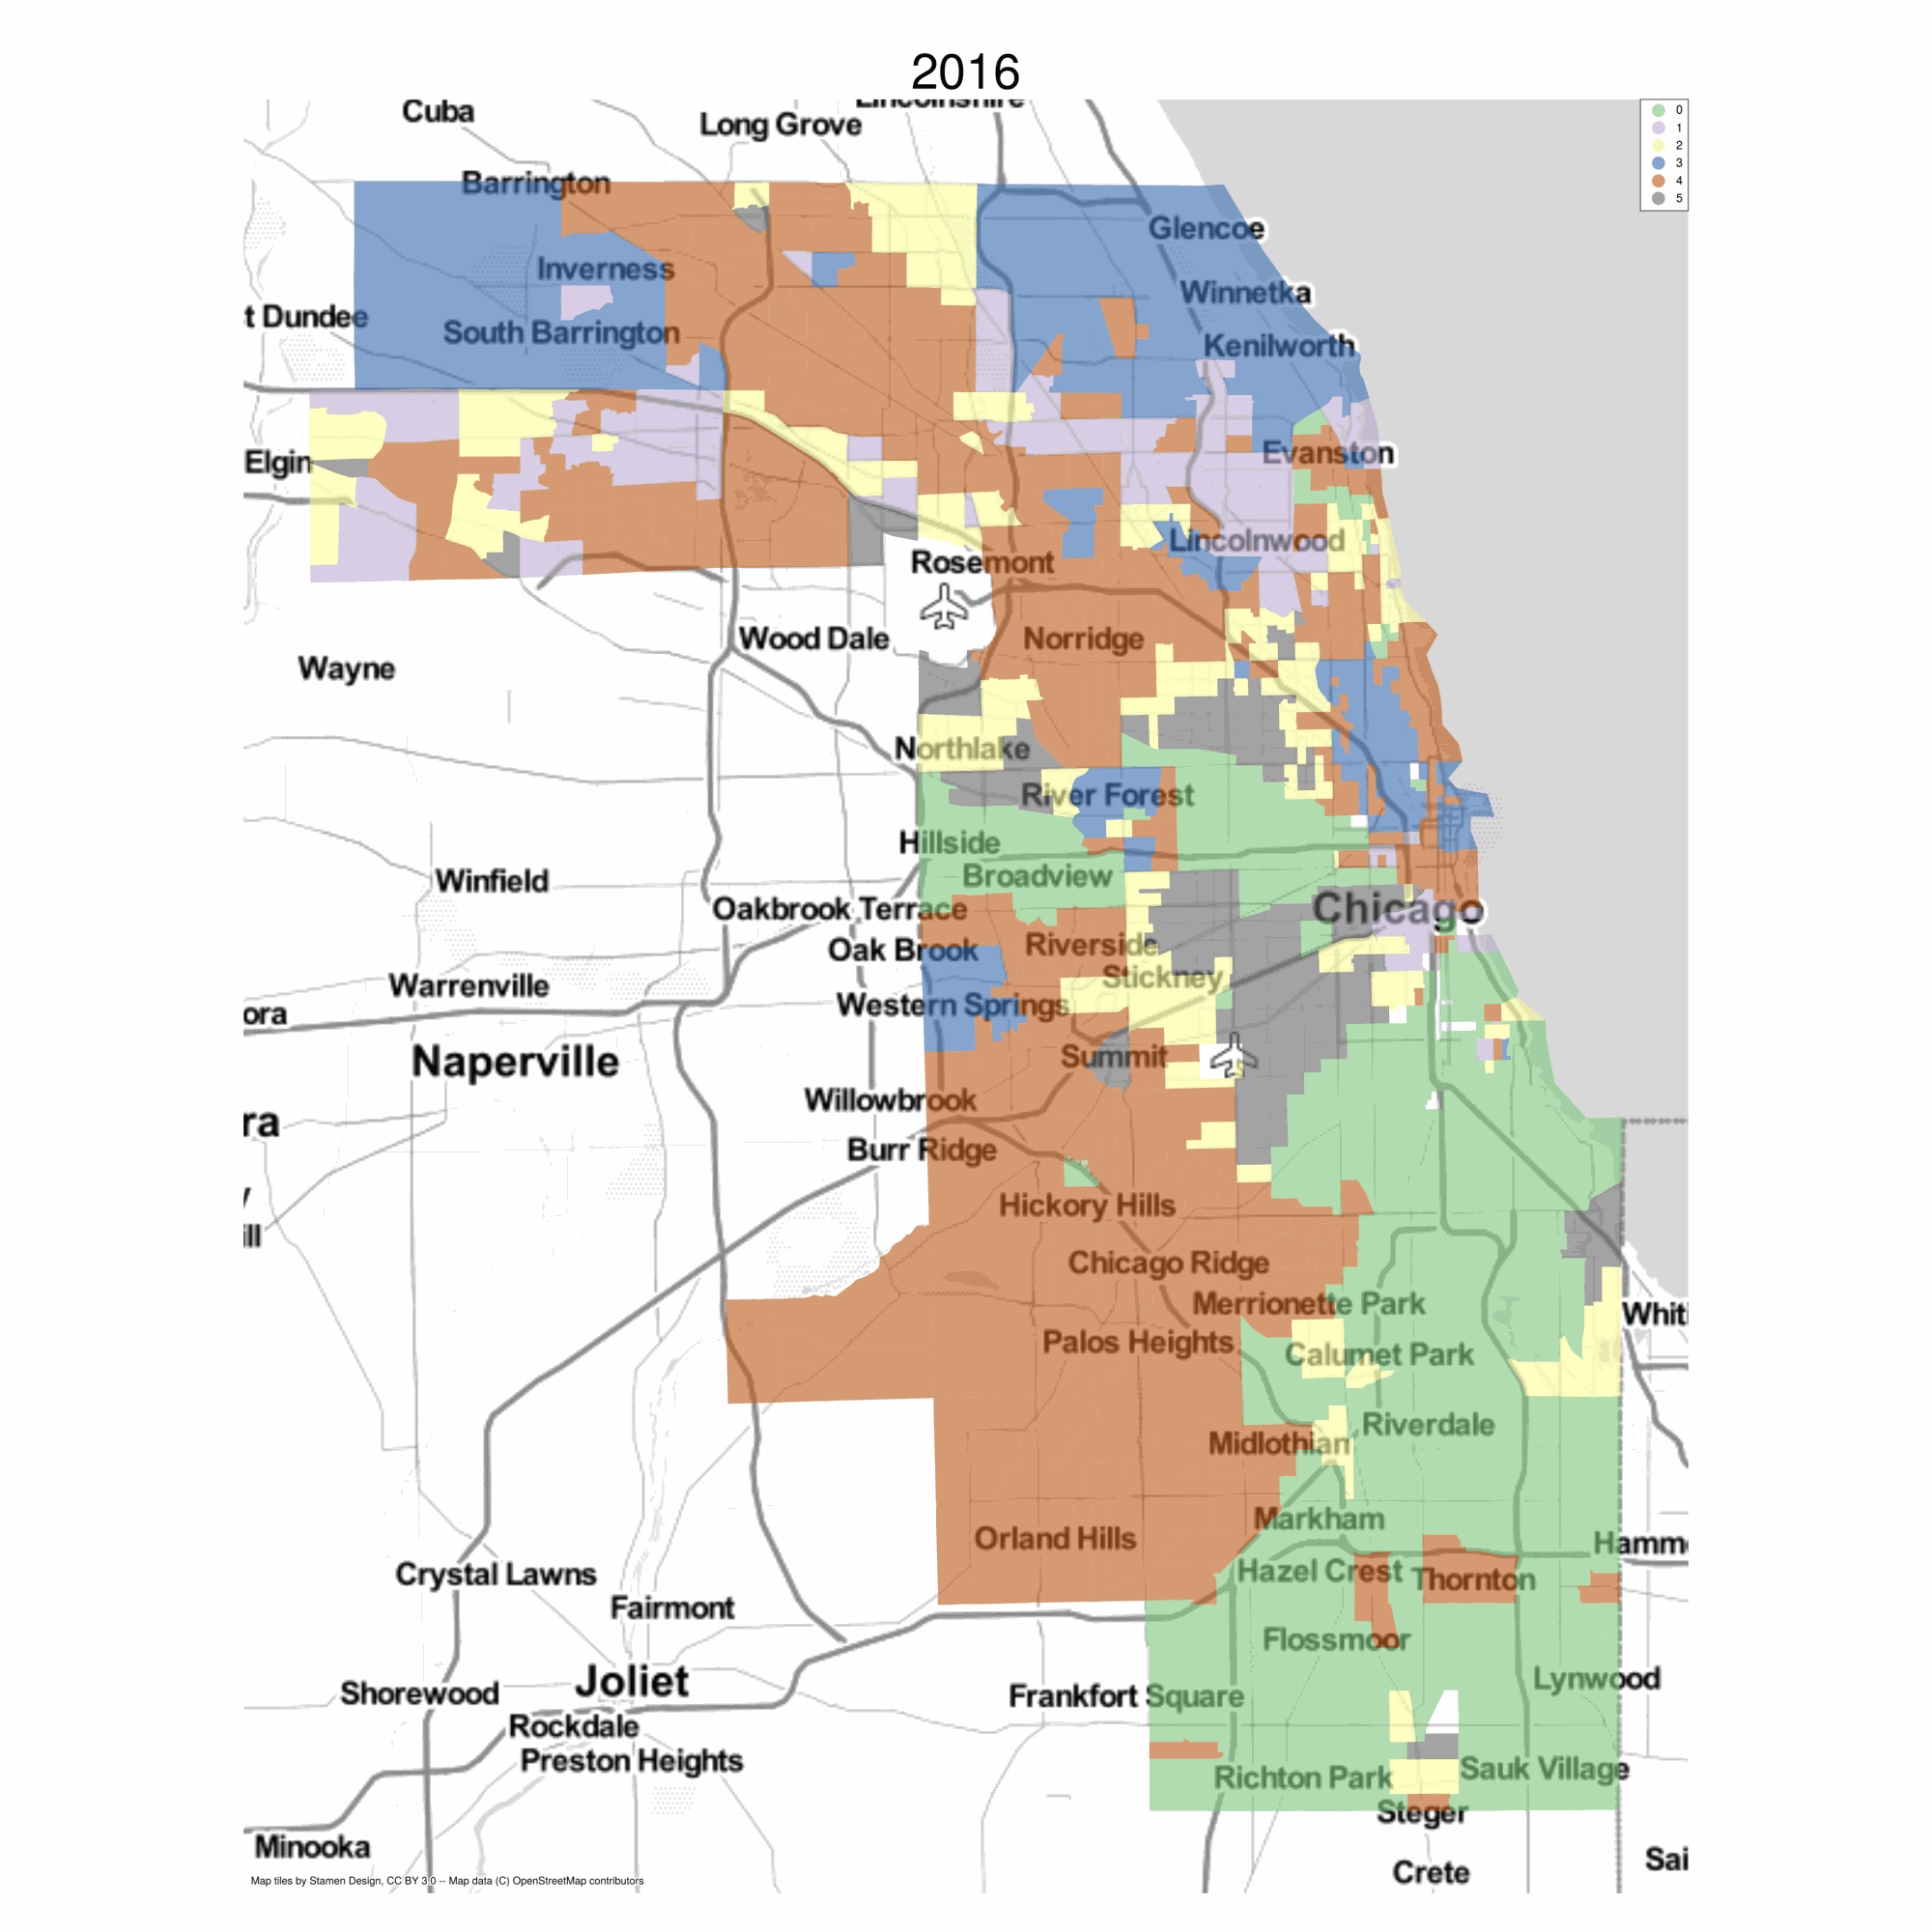

In [38]:
Image('figs/chicago_predictions.gif', width=800)

From a social equity perspective, these predictions can help inform investments in place that are likely to provide the greatest return, such as providing place-based affordable houising in high-opportunity (but low likelihood of change) or by providing displacement protections in places that show large potential for change